In [18]:
import matplotlib as mpl
import cartopy.crs as ccrs
import os, sys
import xarray as xr
import numpy as np
import scipy.stats as st
import xrft
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import netCDF4 as nc
import matplotlib.ticker as mticker
from matplotlib import colors
import k_omega_functions as kw
import numpy_groupies
from scipy import signal
from scipy.stats import linregress


In [19]:
def temporal_spectrum(KE_in, dt):
# Function to compute k_omega spectrum
# KE_in : KE (time_counter, y, x) (loaded with xarray)
# ds_coord : dataset which contains the coordinates(at least e1t & e2t)
    no=0
    dt_inv = 1 / dt
    KE_flat = KE_in.stack(xy=("x", "y"))
    KE_flat = KE_flat.where(~np.isnan(KE_flat.values), 0.)
    
    ff_KE=np.zeros(KE_flat.shape)
    ff_KEki0=np.zeros(KE_flat.shape)

    for i in range(len(KE_flat[0,:])):
#         print(str(i) +' / '+ str(len(KE_flat[0,:])))
#         print(i, len(KE_flat[0,:]))
        ff_KE[:,i], ff_KEki0[:,i] = signal.welch(KE_flat[:,i], fs=dt_inv,nperseg=int(len(KE_flat[:,0])),\
                                                        window='hanning', noverlap=no,nfft=2*int(len(KE_flat[:,0])-1),\
                                                        detrend='linear', return_onesided=True, scaling='spectrum')
    mean_f0_KE = np.nanmean(ff_KE,axis=1)
    mean_fi0_KE = np.nanmean(ff_KEki0,axis=1)
    
    
    return mean_f0_KE, mean_fi0_KE

    

In [20]:
def spatial_spectrum(KE_in, dx):
# Function to compute k_omega spectrum
# KE_in : KE (time_counter, y, x) (loaded with xarray)
# ds_coord : dataset which contains the coordinates(at least e1t & e2t)
    no=0
    dx_inv = 1 / dx
 
    KE = KE_in.where(~np.isnan(KE_in.values), 0.)
    
    ff_KE=np.zeros(KE.shape)
    ff_KEki0=np.zeros(KE.shape)
    for t in range(len(KE[:,0,0])):
        print(t)
        for j in range(len(KE[0,0,:])):
            ff_KE[t,:,j], ff_KEki0[t,:,j] = signal.welch(KE[t,:,j], fs=dx_inv,nperseg=int(len(KE[0,:,0])),\
                                                    window='hanning', noverlap=no,nfft=2*int(len(KE[0,:,0])-1),\
                                                    detrend='linear', return_onesided=True, scaling='spectrum')
    mean_f0_KE = np.nanmean(ff_KE,axis=(0,2))
    mean_fi0_KE = np.nanmean(ff_KEki0,axis=(0,2))

    
    return mean_f0_KE, mean_fi0_KE

    

In [38]:
# Define area names
areanames=['ATL_46N']
colors=['r']
listlat_center=np.array([46])
listlon_center=np.array([-7])
dx = [2193]
dy = [2169]


DSTART='2017-06-01'
DEND='2017-09-01'
season='JJA'

# DSTART='2017-12-01'
# DEND='2018-03-01'
# season='DJF'

In [22]:
fldr_1 = '/data/vdi/tbrivoal/RUNS_DATA/EXP02_AGRIF_finaldomain_bathycorrected_qco_boost2_noslip/'
fldr_2 = '/data/vdi/tbrivoal/RUNS_DATA/eNEATL36_trunk_r4_2-RC_r15113_IFS_EXP02_2017_2018_AGRIFTWIN_BFR/'
fldr_plots ='/home/tbrivoal/Documents/PLOTS/SPECTRUMS/'

In [23]:
for narea in range(len(listlat_center)):
    # Selecting SSH area
    # This part is to extract the dx and dy 

    file_U_1 = fldr_1+'eNEATL36_1h_gridU_'+str(areanames[narea])+'.nc'
    file_V_1 = fldr_1+'eNEATL36_1h_gridV_'+str(areanames[narea])+'.nc'
    file_KE_1 = fldr_1+'eNEATL36_1h_gridKE_'+str(areanames[narea])+'.nc'

    file_U_2 = fldr_2+'eNEATL36_1h_gridU_'+str(areanames[narea])+'.nc'
    file_V_2 = fldr_2+'eNEATL36_1h_gridV_'+str(areanames[narea])+'.nc'
    file_KE_2 = fldr_2+'eNEATL36_1h_gridKE_'+str(areanames[narea])+'.nc'
    
    # The better is to pre-compute KE, as it takes a long time to compute
    isfile1 = os.path.isfile(file_KE_1)
    isfile2 = os.path.isfile(file_KE_2)

    if isfile1 and isfile2:
        print('KE files exists, skipping KE computation part')
        print('loading file : ', file_KE_1)
        print('loading file : ', file_KE_2)

        ds_KE_1 = xr.open_dataset(file_KE_1)
        ds_KE_2 = xr.open_dataset(file_KE_2)

        KE_1 = ds_KE_1.KE.sel(time_counter=slice(DSTART, DEND))
        KE_2 = ds_KE_2.KE.sel(time_counter=slice(DSTART, DEND))
        print(KE_1.shape)
    else:
    
        ds_U_1 = xr.open_dataset(file_U_1)
        ds_V_1 = xr.open_dataset(file_V_1)
        ds_U_2 = xr.open_dataset(file_U_2)
        ds_V_2 = xr.open_dataset(file_V_2)
        U_1 = ds_U_1.sozocrtx.squeeze()
        V_1 = ds_V_1.somecrty.squeeze()
        U_2 = ds_U_2.sozocrtx.squeeze()
        V_2 = ds_V_2.somecrty.squeeze()
        KE_1 = 0.5 * (U_1.rename('KE')**2 + V_1.rename('KE')**2)
        KE_2 = 0.5 * (U_2.rename('KE')**2 + V_2.rename('KE')**2)
        KE_1.to_netcdf(file_KE_1)
        KE_2.to_netcdf(file_KE_2)
        KE_1 = KE_1.sel(time_counter=slice(DSTART, DEND))
        KE_1 = KE_1.sel(time_counter=slice(DSTART, DEND))        
    dt = 3600. 
    mean_f0_KE_1, mean_fi0_KE_1 = temporal_spectrum(KE_1, dt)
    mean_f0_KE_2, mean_fi0_KE_2 = temporal_spectrum(KE_2, dt)
    


KE files exists, skipping KE computation part
loading file :  /data/vdi/tbrivoal/RUNS_DATA/EXP02_AGRIF_finaldomain_bathycorrected_qco_boost2_noslip/eNEATL36_1h_gridKE_ATL_46N.nc
loading file :  /data/vdi/tbrivoal/RUNS_DATA/eNEATL36_trunk_r4_2-RC_r15113_IFS_EXP02_2017_2018_AGRIFTWIN_BFR/eNEATL36_1h_gridKE_ATL_46N.nc
(2232, 180, 180)


[0.00000000e+00 6.22540963e-08 1.24508193e-07 ... 1.38764381e-04
 1.38826635e-04 1.38888889e-04]
FIG SAVED HERE: /home/tbrivoal/Documents/PLOTS/SPECTRUMS/temporal_spectrumATL_46N_JJA.png


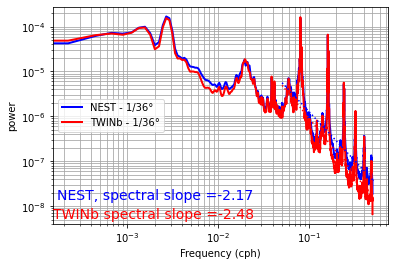

In [41]:
ax00 = plt.subplot(111)
# fig.set_tight_layout(True)

# mean_f0_KE_1_h = mean_f0_KE_1 *3600
# mean_f0_KE_2_h = mean_f0_KE_2 *3600
print(mean_f0_KE_2)
ax00.loglog(mean_f0_KE_1_h, mean_fi0_KE_1, 'b', lw=2, label ='NEST - 1/36°')
ax00.loglog(mean_f0_KE_2_h, mean_fi0_KE_2, 'r', lw=2, label ='TWINb - 1/36°')
ax00.legend(loc='center left')
ax00.set_ylabel('power') # regex: ($10log10$)
ax00.set_xlabel('Frequency (cph)')
seuil_slope=5* 10**(-2)
mean_f0_KE_1_h_slpe = mean_f0_KE_1_h[mean_f0_KE_1_h > seuil_slope]
mean_fi0_KE_1_slpe = mean_fi0_KE_1[mean_f0_KE_1_h > seuil_slope]
mean_f0_KE_2_h_slpe = mean_f0_KE_2_h[mean_f0_KE_2_h > seuil_slope]
mean_fi0_KE_2_slpe = mean_fi0_KE_2[mean_f0_KE_2_h > seuil_slope]

slope_1, intercept_1, r_value, p_value, std_err= linregress( np.log10(mean_f0_KE_1_h_slpe[2::]), np.log10(mean_fi0_KE_1_slpe[2::]) )
slope_2, intercept_2, r_value, p_value, std_err= linregress( np.log10(mean_f0_KE_2_h_slpe[2::]), np.log10(mean_fi0_KE_2_slpe[2::]) )

ax00.loglog(10**(np.log10(mean_f0_KE_1_h_slpe[2::])), 10**(slope_1 * np.log10(mean_f0_KE_1_h_slpe[2::]) + intercept_1),linestyle='dotted',color='b')
ax00.loglog(10**(np.log10(mean_f0_KE_1_h_slpe[2::])), 10**(slope_2 * np.log10(mean_f0_KE_1_h_slpe[2::]) + intercept_2),linestyle='dotted',color='r')


plt.grid(True, which="both", linestyle='-', color='0.65')

ax00.text(0.6, 0.1, 'NEST, spectral slope =' +str('{:.2f}'.format(slope_1)),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax00.transAxes,
        color='b', fontsize=14)

ax00.text(0.6, 0.01, 'TWINb spectral slope =' +str('{:.2f}'.format(slope_2)),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax00.transAxes,
        color='r', fontsize=14)

plt.grid(True, which="both", linestyle='-', color='0.65')

plt.savefig(fldr_plots + 'temporal_spectrum'+str(areanames[narea])+'_'+season+'.png')
print('FIG SAVED HERE: ' + fldr_plots + 'temporal_spectrum'+str(areanames[narea])+'_'+season+'.png')

In [25]:
for narea in range(len(listlat_center)):
    # Selecting SSH area
    # This part is to extract the dx and dy 

    file_U_1 = fldr_1+'eNEATL36_1h_gridU_'+str(areanames[narea])+'.nc'
    file_V_1 = fldr_1+'eNEATL36_1h_gridV_'+str(areanames[narea])+'.nc'
    file_KE_1 = fldr_1+'eNEATL36_1h_gridKE_'+str(areanames[narea])+'.nc'

    file_U_2 = fldr_2+'eNEATL36_1h_gridU_'+str(areanames[narea])+'.nc'
    file_V_2 = fldr_2+'eNEATL36_1h_gridV_'+str(areanames[narea])+'.nc'
    file_KE_2 = fldr_2+'eNEATL36_1h_gridKE_'+str(areanames[narea])+'.nc'
    
    # The better is to pre-compute KE, as it takes a long time to compute
    isfile1 = os.path.isfile(file_KE_1)
    isfile2 = os.path.isfile(file_KE_2)

    if isfile1 and isfile2:
        print('KE files exists, skipping KE computation part')
        print('loading file : ', file_KE_1)
        print('loading file : ', file_KE_2)

        ds_KE_1 = xr.open_dataset(file_KE_1)
        ds_KE_2 = xr.open_dataset(file_KE_2)

        KE_1 = ds_KE_1.KE.sel(time_counter=slice(DSTART, DEND))
        KE_2 = ds_KE_2.KE.sel(time_counter=slice(DSTART, DEND))
    else:
    
        ds_U_1 = xr.open_dataset(file_U_1)
        ds_V_1 = xr.open_dataset(file_V_1)
        ds_U_2 = xr.open_dataset(file_U_2)
        ds_V_2 = xr.open_dataset(file_V_2)
        U_1 = ds_U_1.sozocrtx.squeeze()
        V_1 = ds_V_1.somecrty.squeeze()
        U_2 = ds_U_2.sozocrtx.squeeze()
        V_2 = ds_V_2.somecrty.squeeze()
        KE_1 = 0.5 * (U_1.rename('KE')**2 + V_1.rename('KE')**2)
        KE_2 = 0.5 * (U_2.rename('KE')**2 + V_2.rename('KE')**2)
        KE_1.to_netcdf(file_KE_1)
        KE_2.to_netcdf(file_KE_2)
        KE_1 = KE_1.sel(time_counter=slice(DSTART, DEND))
        KE_1 = KE_1.sel(time_counter=slice(DSTART, DEND))        
    dx_in = dx[narea]
    mean_f0s_KE_1, mean_fi0s_KE_1 = spatial_spectrum(KE_1, dx_in)
    mean_f0s_KE_2, mean_fi0s_KE_2 = spatial_spectrum(KE_2, dx_in)
    


KE files exists, skipping KE computation part
loading file :  /data/vdi/tbrivoal/RUNS_DATA/EXP02_AGRIF_finaldomain_bathycorrected_qco_boost2_noslip/eNEATL36_1h_gridKE_ATL_46N.nc
loading file :  /data/vdi/tbrivoal/RUNS_DATA/eNEATL36_trunk_r4_2-RC_r15113_IFS_EXP02_2017_2018_AGRIFTWIN_BFR/eNEATL36_1h_gridKE_ATL_46N.nc
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
1

1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997


1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626


In [26]:
dx[narea]

2193

FIG SAVED HERE: /home/tbrivoal/Documents/PLOTS/SPECTRUMS/spatial_spectrumATL_46N_JJA.png


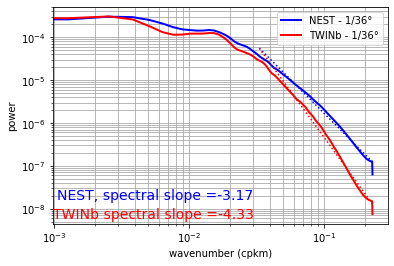

In [40]:
ax00 = plt.subplot(111)
# fig.set_tight_layout(True)

mean_f0s_KE_1_km = mean_f0s_KE_1 *1000
mean_f0s_KE_2_km = mean_f0s_KE_2 *1000

ax00.loglog(mean_f0s_KE_1_km, mean_fi0s_KE_1, 'b', lw=2, label ='NEST - 1/36°')
ax00.loglog(mean_f0s_KE_2_km, mean_fi0s_KE_2, 'r', lw=2, label ='TWINb - 1/36°')

# ax00.plot(np.log10(mean_f0s_KE_1_km), np.log10(mean_fi0s_KE_1), 'b', lw=2, label ='NEST - 1/36°')
# ax00.plot(np.log10(mean_f0s_KE_2_km), np.log10(mean_fi0s_KE_2), 'r', lw=2, label ='TWIN - 1/36°')
ax00.legend()
ax00.set_ylabel('power') # regex: ($10log10$)
ax00.set_xlabel('wavenumber (cpkm)')
seuil_slope = 3*10**(-2)
mean_f0s_KE_1_km_slpe = mean_f0s_KE_1_km[mean_f0s_KE_1_km > seuil_slope]
mean_fi0s_KE_1_slpe = mean_fi0s_KE_1[mean_f0s_KE_1_km > seuil_slope]
mean_f0s_KE_2_km_slpe = mean_f0s_KE_2_km[mean_f0s_KE_2_km > seuil_slope]
mean_fi0s_KE_2_slpe = mean_fi0s_KE_2[mean_f0s_KE_2_km > seuil_slope]


slope_1, intercept_1, r_value, p_value, std_err= linregress( np.log10(mean_f0s_KE_1_km_slpe[2::]), np.log10(mean_fi0s_KE_1_slpe[2::]) )
slope_2, intercept_2, r_value, p_value, std_err= linregress( np.log10(mean_f0s_KE_2_km_slpe[2::]), np.log10(mean_fi0s_KE_2_slpe[2::]) )

ax00.loglog(10**(np.log10(mean_f0s_KE_1_km_slpe[2::])), 10**(slope_1 * np.log10(mean_f0s_KE_1_km_slpe[2::]) + intercept_1),linestyle='dotted',color='b')
ax00.loglog(10**(np.log10(mean_f0s_KE_2_km_slpe[2::])), 10**(slope_2 * np.log10(mean_f0s_KE_2_km_slpe[2::]) + intercept_2),linestyle='dotted',color='r')


plt.grid(True, which="both", linestyle='-', color='0.65')

ax00.text(0.6, 0.1, 'NEST, spectral slope =' +str('{:.2f}'.format(slope_1)),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax00.transAxes,
        color='b', fontsize=14)

ax00.text(0.6, 0.01, 'TWINb spectral slope =' +str('{:.2f}'.format(slope_2)),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax00.transAxes,
        color='r', fontsize=14)

plt.savefig(fldr_plots + 'spatial_spectrum'+str(areanames[narea])+'_'+season+'.png')
print('FIG SAVED HERE: ' + fldr_plots + 'spatial_spectrum'+str(areanames[narea])+'_'+season+'.png')

In [28]:
# # Store for later

# mean_f0s_KE_1_DJF, mean_fi0s_KE_1_DJF = mean_f0s_KE_1, mean_fi0s_KE_1 
# mean_f0s_KE_2_DJF, mean_fi0s_KE_2_DJF = mean_f0s_KE_2, mean_fi0s_KE_2 
# mean_f0_KE_1_h_DJF, mean_fi0_KE_1_DJF = mean_f0_KE_1_h, mean_fi0_KE_1
# mean_f0_KE_2_h_DJF, mean_fi0_KE_2_DJF = mean_f0_KE_2_h, mean_fi0_KE_2




In [29]:
# Store for later

mean_f0s_KE_1_JJA, mean_fi0s_KE_1_JJA = mean_f0s_KE_1, mean_fi0s_KE_1 
mean_f0s_KE_2_JJA, mean_fi0s_KE_2_JJA = mean_f0s_KE_2, mean_fi0s_KE_2 
mean_f0_KE_1_h_JJA, mean_fi0_KE_1_JJA = mean_f0_KE_1_h, mean_fi0_KE_1
mean_f0_KE_2_h_JJA, mean_fi0_KE_2_JJA = mean_f0_KE_2_h, mean_fi0_KE_2




In [39]:

mean_f0s_KE_1, mean_fi0s_KE_1 = mean_f0s_KE_1_JJA, mean_fi0s_KE_1_JJA 
mean_f0s_KE_2, mean_fi0s_KE_2 = mean_f0s_KE_2_JJA, mean_fi0s_KE_2_JJA
mean_f0_KE_1_h, mean_fi0_KE_1 = mean_f0_KE_1_h_JJA, mean_fi0_KE_1_JJA
mean_f0_KE_2_h, mean_fi0_KE_2 = mean_f0_KE_2_h_JJA, mean_fi0_KE_2_JJA
mean_f0_KE_1_h.shape, 

((2232,),)